In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score
import pandas as pd
import seaborn as sns
from statsmodels import api as sm
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import os
import numpy as np
import math
import validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import PR_curve
from sklearn.cluster import KMeans

In [2]:
data_dir='fixed_csv_label_ver2'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

,original,label,time,day
0,53.4,0,15,0
1,52.8,0,15,0
2,52.8,0,15,0
3,53.2,0,15,0
4,53.6,0,15,0
...,...,...,...,...
3995345,45.9,0,5,9
3995346,45.6,0,5,9
3995347,45.8,0,5,9
3995348,45.7,0,5,9


In [3]:
def make_data(x, str,w):
    x=pd.DataFrame(x)
    window=w
    for i in range(1, window):
        column=f'{str}_lag{i}'
        x[column]=x[str].shift(i)
    return x

def make_label(x, w):
    window=w
    x['label_all']=x['label']
    for i in range(1, window):
        x.loc[(x['label_all']==1)|(x['label'].shift(i)==1), 'label_all']=1
        x.loc[(x['label_all']==0)&(x['label'].shift(i)==0), 'label_all']=0
    
    x['label']=x['label_all']
    return x[['label']]

df_list=[]
for i in set(df['day']):
    lag=[] 
    window=5
    lag.append(make_data(df.loc[df['day']==i, ['original']], 'original', window))
    lag.append(df.loc[df['day']==i, ['day']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
df=pd.concat(df_list)
df=df.dropna().reset_index(drop=True)
df['d']=0
df['z']=0
df

,original,original_lag1,original_lag2,original_lag3,original_lag4,day,d,z
0,53.6,53.2,52.8,52.8,53.4,0,0,0
1,54.0,53.6,53.2,52.8,52.8,0,0,0
2,54.7,54.0,53.6,53.2,52.8,0,0,0
3,55.7,54.7,54.0,53.6,53.2,0,0,0
4,55.5,55.7,54.7,54.0,53.6,0,0,0
...,...,...,...,...,...,...,...,...
3995305,45.9,45.6,45.4,45.9,46.0,9,0,0
3995306,45.6,45.9,45.6,45.4,45.9,9,0,0
3995307,45.8,45.6,45.9,45.6,45.4,9,0,0
3995308,45.7,45.8,45.6,45.9,45.6,9,0,0


## 異常ラベル付与

In [4]:
f_score_sum=0
for i in set(df['day']):
    print(f'{i}日目')

    test_day=[i]
    train=df[(~df['day'].isin(test_day))][df.columns[:-3]].reset_index(drop=True)
    test=df[(df['day'].isin(test_day))][df.columns[:-3]].reset_index(drop=True)

    nk = 21
    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(train)
    d = neigh.kneighbors(test)[0]
    d = np.mean(d, axis=1)
    mx = np.max(d)
    d = d / mx

    test_v=original[original['day'].isin(test_day)][['original', 'label']].reset_index(drop=True)
    test_v['d']=d[0]
    test_v.loc[window-1:, 'd']=d
 
    #kmeans
    n_clusters=4
    model = KMeans(n_clusters=n_clusters)  
    model.fit(d.reshape((-1, 1)))
    clusters = model.predict(d.reshape((-1, 1)))  
    result=pd.DataFrame({'d':d, 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].max())
    thr=sorted(thr_list)[-2]
    print(f'閾値{thr}')
    
    d_test=test_v['d'].values
    precision, recall=validate.validate(test_v, d_test, thr)
    f_score=(2*precision*recall)/(precision+recall)
    print(f'適合率：{precision}')
    print(f'再現率：{recall}')
    print(f'f値：{f_score}')
    f_score_sum+=f_score

    z=np.where(d>=thr, 1, 0)
    df.loc[(df['day'].isin(test_day)), 'd']=d
    df.loc[(df['day'].isin(test_day)), 'z']=z
    print('-----------------------------------------------')
f_mean=f_score_sum/len(set(df['day']))
print(f'f値平均：{f_mean}')

0日目
閾値0.22251273394366253
適合率：0.9201954397394136
再現率：0.7264957264957265
f値：0.8119531679276385
-----------------------------------------------
1日目
閾値0.22136451980569774
適合率：0.9450841452612931
再現率：0.8953488372093024
f値：0.9195444752231456
-----------------------------------------------
2日目
閾値0.12012500791025607
適合率：0.8727876106194691
再現率：0.84375
f値：0.8580231996133398
-----------------------------------------------
3日目
閾値0.20336772287714008
適合率：0.7720286885245902
再現率：0.9655172413793104
f値：0.8579997763295684
-----------------------------------------------
4日目
閾値0.12824636816738072
適合率：0.9206521739130434
再現率：0.890625
f値：0.9053896931963092
-----------------------------------------------
5日目
閾値0.19978562960438057
適合率：0.8425531914893617
再現率：0.9714285714285714
f値：0.9024128686327078
-----------------------------------------------
6日目
閾値0.1637998172344294
適合率：0.7688073394495413
再現率：0.8611111111111112
f値：0.8123456018011821
-----------------------------------------------
7日目
閾値0.13900612709668375
適合

# kmeansによる閾値

In [5]:
from sklearn.cluster import KMeans
n_clusters=4
for i in df['day'].unique():
    day=i
    model = KMeans(n_clusters=n_clusters, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
    model.fit(df.loc[df['day']==day, ['d']].values)
    clusters = model.predict(df.loc[df['day']==0, ['d']].values)  
    result=pd.DataFrame({'d':df.loc[df['day']==0, 'd'].values, 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].min())
    thr=sorted(thr_list)[-1]
    print(f'{i}日目閾値{thr}')

0日目閾値0.22280878743579904
1日目閾値0.22135304729424793
2日目閾値0.12028423034351117
3日目閾値0.20344710895437346
4日目閾値0.12859112365954584
5日目閾値0.2021276472771629
6日目閾値0.16386467997083498
7日目閾値0.1391221999294059
8日目閾値0.15028568388767186
9日目閾値0.18130753970147157


In [6]:
from sklearn.cluster import KMeans
n_clusters=4
for i in df['day'].unique():
    day=i
    model = KMeans(n_clusters=n_clusters, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
    model.fit(df.loc[df['day']==day, ['d']].values)
    clusters = model.predict(df.loc[df['day']==0, ['d']].values)  
    result=pd.DataFrame({'d':df.loc[df['day']==0, 'd'].values, 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].min())
    thr_min=sorted(thr_list)[-2]
    thr_max=sorted(thr_list)[-1]
    thr_range=result.loc[(result['d']>=thr_min)&(result['d']<=thr_max), ['d']]
    Q1 = thr_range.quantile(0.25)
    Q3 = thr_range.quantile(0.75)
    IQR = Q3 - Q1
    thr = min(float(Q3 + 1.5 * IQR), thr_max)
    print(f'{i}日目閾値{thr}')

0日目閾値0.19442624211088805
1日目閾値0.2109589977341114
2日目閾値0.11759890733110245
3日目閾値0.1862821240816419
4日目閾値0.12678075436256547
5日目閾値0.18025860666228724
6日目閾値0.14394360403723394
7日目閾値0.13591443118045507
8日目閾値0.14893229768467148
9日目閾値0.17731257901634206


In [7]:
d_range=result.loc[(result['d']>=sorted(thr_list)[-2])&(result['d']<=sorted(thr_list)[-1]), 'd'].values

{'whiskers': [<matplotlib.lines.Line2D at 0x17181ece190>,
 'caps': [<matplotlib.lines.Line2D at 0x17182baf2b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x171824b5310>],
 'medians': [<matplotlib.lines.Line2D at 0x17182bafb20>],
 'fliers': [<matplotlib.lines.Line2D at 0x17181eca8e0>],
 'means': []}

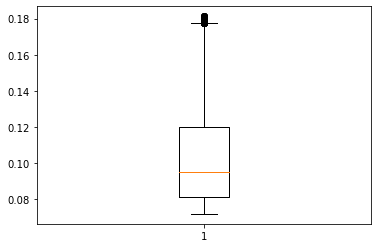

In [8]:
plt.boxplot(d_range)

In [9]:
from sklearn.cluster import KMeans
n_clusters=4
for i in df['day'].unique():
    day=i
    d_df=df.loc[df['day']==day, ['d']].copy()
    d_sample=d_df.sample(n=54000)
    model = KMeans(n_clusters=n_clusters, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
    model.fit(d_sample.values)
    clusters = model.predict(d_sample.values)  
    result=pd.DataFrame({'d':d_sample.values.flatten(), 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].min())
    print(f'{i}日目閾値{sorted(thr_list)[-2]}')

0日目閾値0.06530100203130428
1日目閾値0.09288009957679284
2日目閾値0.06441211408135689
3日目閾値0.0732538004578138
4日目閾値0.06091197845100788
5日目閾値0.07308268632579155
6日目閾値0.03952110580676834
7日目閾値0.05440096970072625
8日目閾値0.06149247062141193
9日目閾値0.06541971059595729


2クラスタ


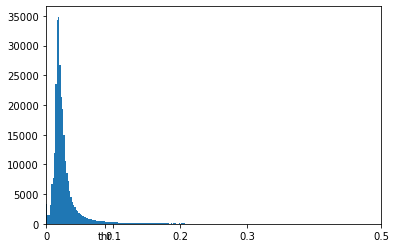

3クラスタ


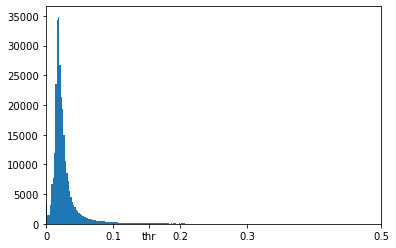

4クラスタ


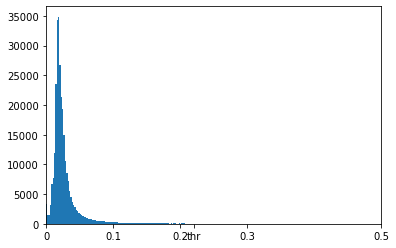

5クラスタ


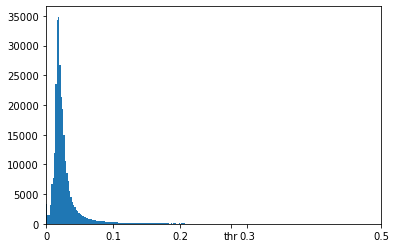

6クラスタ


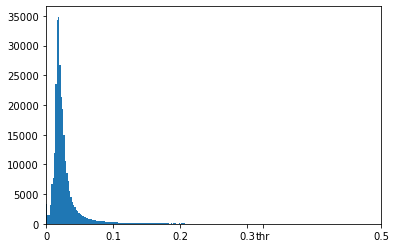

7クラスタ


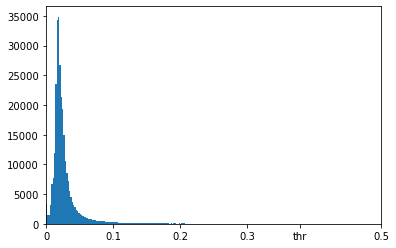

In [10]:
day=1
for j  in range(2,8):  
    print(f'{j}クラスタ')
    model = KMeans(n_clusters=j, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
    model.fit(df.loc[df['day']==day, ['d']].values)
    clusters = model.predict(df.loc[df['day']==0, ['d']].values)  
    result=pd.DataFrame({'d':df.loc[df['day']==0, 'd'].values, 'cluster':clusters})
    thr_list=[]
    for j in range(j):
        thr_list.append(result.loc[result['cluster']==j, 'd'].min())
    plt.hist(df.loc[df['day']==day, 'd'], bins=500)
    plt.xticks([0, 0.1, 0.2, 0.3, 0.5, sorted(thr_list)[-1]], ["0", "0.1", "0.2", "0.3", "0.5", "thr"])
    plt.xlim(0, 0.5)
    plt.show()

0日目


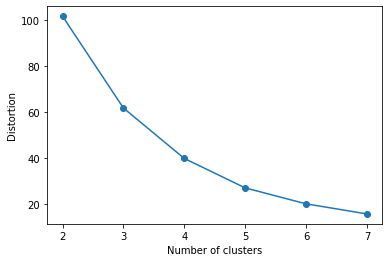

1日目


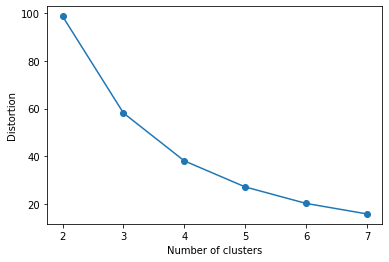

2日目


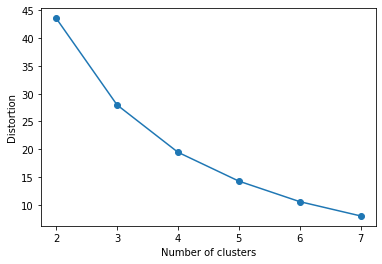

3日目


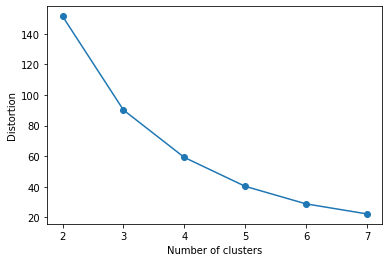

4日目


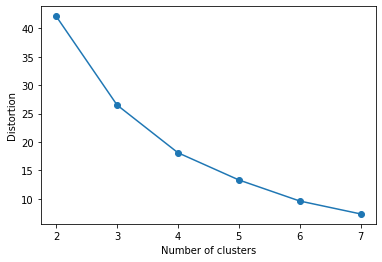

5日目


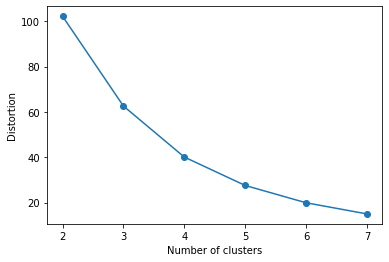

6日目


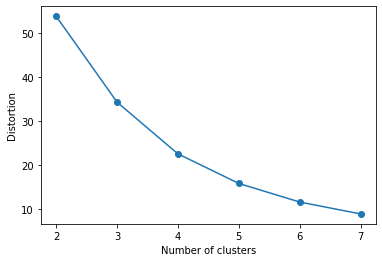

7日目


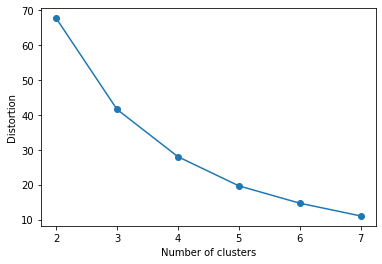

8日目


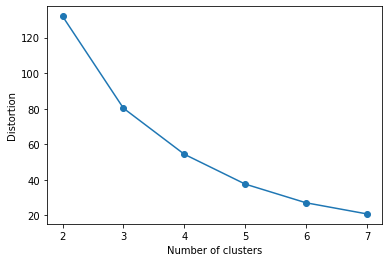

9日目


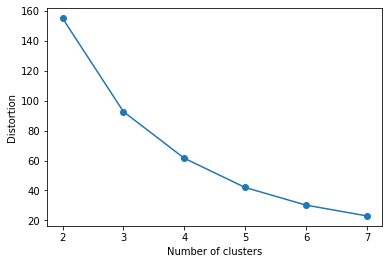

In [11]:
for i in df['day'].unique():
    day=i
    distortions = []
    print(f'{i}日目')
    for j  in range(2,8):  
        model = KMeans(n_clusters=j, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
        model.fit(df.loc[df['day']==day, ['d']].values)
        distortions.append(model.inertia_)
    plt.plot(range(2,8),distortions,marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
        

In [12]:
distortions = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算 
    km = KMeans(n_clusters=i,
                init='k-means++')    # k-means++法によりクラスタ中心を選択

    km.fit(X)                         # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

NameError: name 'X' is not defined

In [ ]:
from sklearn.cluster import KMeans
n_clusters=8
for i in df['day'].unique():
    day=i
    model = KMeans(n_clusters=n_clusters, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
    model.fit(df.loc[df['day']==day, ['d']].values)
    clusters = model.predict(df.loc[df['day']==0, ['d']].values)  
    result=pd.DataFrame({'d':df.loc[df['day']==0, 'd'].values, 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].max())
    print(f'{i}日目閾値\n{sorted(thr_list)}')